<a href="https://colab.research.google.com/github/pingwx/ya.prac/blob/main/12_Time_series/12_RU_Time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Требуется построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [ ]:
# !pip install catboost

In [2]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from matplotlib import pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
URL = # your dataset here

In [4]:
df = pd.read_csv(URL)

In [5]:
df.head(13)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Данные загрузили. Видим датасет из двух столбцов "дата", "значение". Пропусков нет. Будем работать с датасетом как с временным рядом. Преобразуем столбец даты к правильному типу.

In [7]:
try:
    df['datetime'] = pd.to_datetime(df['datetime'])
    print('success')
except:
    print('fail')

success


Сделаем столбец даты индексом.

In [8]:
df = df.set_index('datetime')

Отсортируем датасет по индексу.

In [9]:
df = df.sort_index()

Выполним ресемплирование по одному часу.

In [10]:
df = df.resample('1H').sum()

In [11]:
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Поскольку данные в исходном датасете были отсемплированы по 10 минут, после ресемплинга число строк уменьшилось в 6 раз.

## Анализ

Проанализируем данные. Для начала отресемплируем данные по одному дню, чтобы посмотреть на них с долгосрочной точки зрения.

In [13]:
def decomposed_plots(decomposed):
    plt.figure(figsize=(16, 9))
    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Trend')
    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Seasonality')
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca())
    plt.title('Residuals')
    plt.tight_layout()

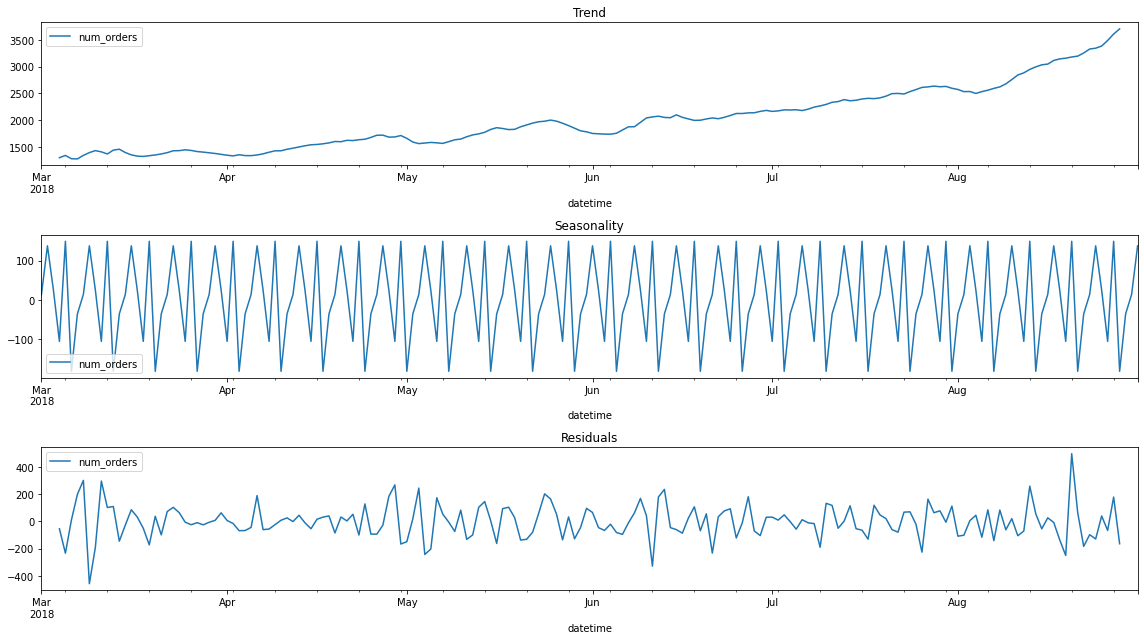

In [14]:
df_resampled_day = df.resample('1D').sum()
decomposed = seasonal_decompose(df_resampled_day)
decomposed_plots(decomposed)

Мы видим, что вдолгосрочной перспективе есть тренд на увеличение количества пользователей. В данных присутствует сезонность, однако из данного графика пока не видно, чем она обусловлена. Также в данных есть некоторый шум. Теперь посмотрим на данные в разрезе одного месяца.

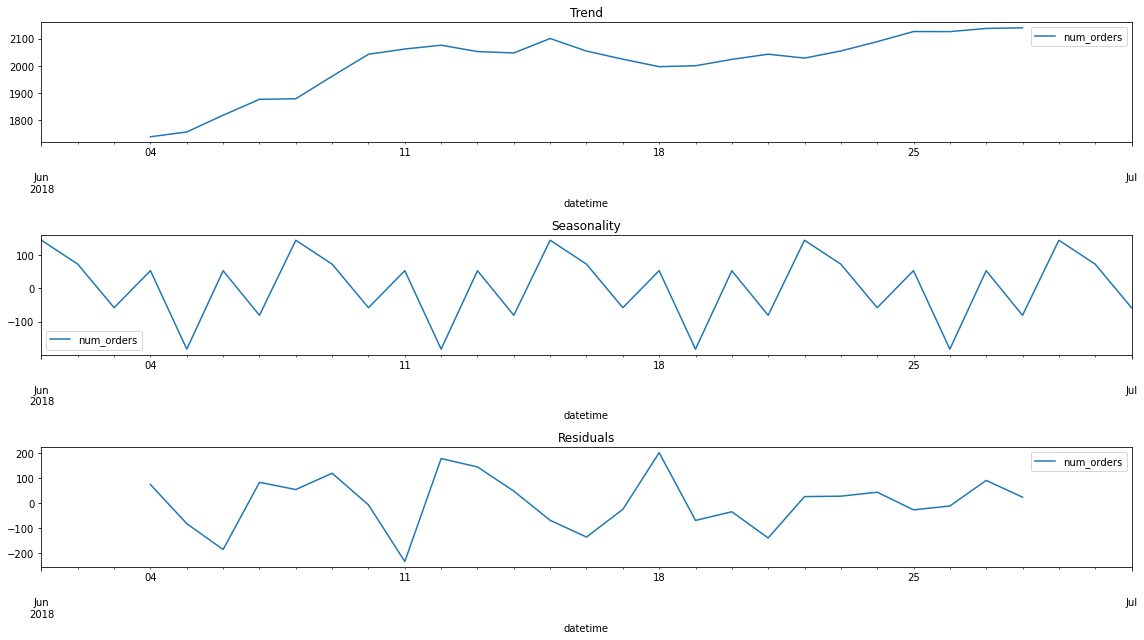

In [15]:
decomposed = seasonal_decompose(df_resampled_day['2018-06-1':'2018-07-1'])
decomposed_plots(decomposed)

В таком приближении лучше понятна сезонная составляющуя. Количество заказов зависит от дня недели (на графике сезонности повторяющиеся участки имеют длину 7 дней). Посмотрим также на данные в масштабе двух дней, чтобы понять, что происходит с заказами в течение одного дня. 

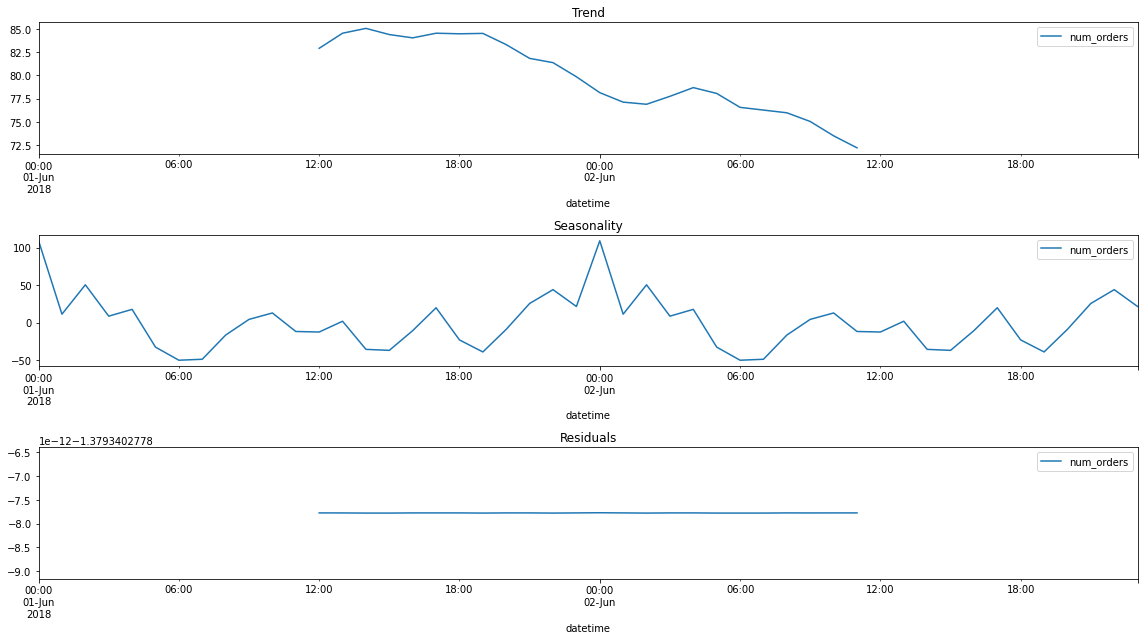

In [16]:
decomposed = seasonal_decompose(df['2018-06-1':'2018-06-2'])
decomposed_plots(decomposed)

Сезонность, зависящая от времени суток также наблюдается. Мы видим, что пик заказов приходится на 00:00, затем идет резкий спад. Утром наблюдается локальный максимум (люди едут на работу), второй локальный максимум приходится на 18:00 (люди едут с работы).

## Обучение

Определим функцую, создающую признаки. Будем добавлять календарные признаки, для которых наблюдается сезонность: месяц, день недели, час суток. Также будем добавлять отстающие значения (lag features) и скользящее среднее. Количество lag features и величину интервалла rolling  определим ниже в константах

In [17]:
MAX_LAG = 256
ROLLING_SIZE = 24

In [18]:
def make_features(data, max_lag, rolling_mean_size):
    data_featured = data.copy()
    data_featured['month'] = data_featured.index.month
    data_featured['hour'] = data_featured.index.hour
    data_featured['dayofweek'] = data_featured.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data_featured['lag_{}'.format(lag)] = data_featured['num_orders'].shift(lag)

    data_featured['rolling_mean'] = data_featured['num_orders'].rolling(rolling_mean_size,
                                                 closed = 'left').mean()
    return data_featured

Добавим в датасет признаки.

In [19]:
df_featured = make_features(df, MAX_LAG, ROLLING_SIZE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # This is added back by InteractiveShellApp.init_path()


In [20]:
df_featured.head()

,num_orders,month,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_248,lag_249,lag_250,lag_251,lag_252,lag_253,lag_254,lag_255,lag_256,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Поскольку в первых строках датасета в стобцах лага будут пропуски, удалим их.

In [21]:
df_featured = df_featured.dropna()

Разобьем датасет на обучающую, валидационную и тестовую выборки

In [22]:
train, test = train_test_split(df_featured, shuffle=False, test_size=0.1)
train, val = train_test_split(train , shuffle=False, test_size=0.1)
train.shape, val.shape, test.shape

((3369, 261), (375, 261), (416, 261))

Убедимся, что даты в выборках идут в правильном порядке.

In [23]:
train.head(1).index

DatetimeIndex(['2018-03-11 16:00:00'], dtype='datetime64[ns]', name='datetime', freq='H')

In [24]:
train.tail(1).index

DatetimeIndex(['2018-07-30'], dtype='datetime64[ns]', name='datetime', freq='H')

In [25]:
val.head(1).index

DatetimeIndex(['2018-07-30 01:00:00'], dtype='datetime64[ns]', name='datetime', freq='H')

In [26]:
val.tail(1).index

DatetimeIndex(['2018-08-14 15:00:00'], dtype='datetime64[ns]', name='datetime', freq='H')

In [27]:
test.head(1).index

DatetimeIndex(['2018-08-14 16:00:00'], dtype='datetime64[ns]', name='datetime', freq='H')

In [28]:
test.tail(1).index

DatetimeIndex(['2018-08-31 23:00:00'], dtype='datetime64[ns]', name='datetime', freq='H')

Порядок верный. Обучим модели.

### Baseline

Посмотрим, какое значение rmse мы получим, если будем всегда предсказывать предыдущее значение ряда.

In [29]:
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_val = val.drop('num_orders', axis=1)
y_val = val['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

In [30]:
pred = np.ones(val.shape[0])
pred[0] = y_train.iloc[len(y_train)-1]
pred[1:] = y_val.shift()[1:]
rmse = mean_squared_error(pred, y_val) ** 0.5
rmse

47.86765087196154

### LinearRegression

In [31]:
lr_model = make_pipeline(StandardScaler(), LinearRegression())
lr_model.fit(X_train, y_train)
pred = lr_model.predict(X_val)
rmse = mean_squared_error(y_val, pred) ** 0.5
rmse

29.169968004447526

### Catboost

In [32]:
cb_model = CatBoostRegressor()
cb_model.fit(X_train, y_train, verbose=200)
pred = cb_model.predict(X_val)
rmse = mean_squared_error(y_val, pred) ** 0.5
rmse

Learning rate set to 0.049605
0:	learn: 35.5076856	total: 218ms	remaining: 3m 38s
200:	learn: 16.6533899	total: 25.2s	remaining: 1m 39s
400:	learn: 13.4260683	total: 52.7s	remaining: 1m 18s
600:	learn: 11.0997398	total: 1m 6s	remaining: 44.5s
800:	learn: 9.1835610	total: 1m 18s	remaining: 19.4s
999:	learn: 7.6947087	total: 1m 29s	remaining: 0us


29.20016906281623

### Torch NN model

In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

#Преобразование значений в torch.Tensor

X_train_tensor = torch.from_numpy(X_train.values.astype(np.float32))
X_val_tensor = torch.from_numpy(X_val.values.astype(np.float32))
y_train_tensor = torch.from_numpy(y_train.values.astype(np.float32))
y_val_tensor = torch.from_numpy(y_val.values.astype(np.float32))
X_test_tensor = torch.from_numpy(X_test.values.astype(np.float32))
y_test_tensor = torch.from_numpy(y_test.values.astype(np.float32))
y_train_tensor = y_train_tensor.unsqueeze(1)
y_val_tensor = y_val_tensor.unsqueeze(1)

Using cpu device


In [34]:
#Создаем дата-лоадеры
BATCH_SIZE = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [35]:
#Архитектура самой модели
nn_model = nn.Sequential(
    nn.Linear(X_train.shape[1], 128),
    nn.ReLU(),
    nn.Dropout(0.6),
    nn.Linear(128,1)
)

In [36]:
#Функция потерь и оптимизатор
nn_model.to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=3e-4)

In [37]:
def train_model(dataloader, model, loss_fn, optimizer):
    num_batches = len(dataloader)
    model.train() #модель в режим train
    for batch, (X, y) in enumerate(dataloader): #итерируемся по батчам
        X, y = X.to(device), y.to(device)
        train_loss = 0
        pred = model(X) #делаем предикт
        loss = loss_fn(pred, y) #считаем лосс на батче
        train_loss += loss.item() #общий лосс на эпохе
        optimizer.zero_grad() #обнулили градиенты
        loss.backward() #посчитали градиенты
        optimizer.step() #сделали шаг по антиградиенту
    train_loss /= num_batches
    print(f"Train avg loss: {train_loss:>8f}")
    
def valid_model(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    model.eval() #модель в режим eval
    test_loss = 0
    with torch.no_grad(): #тут уже градиенты не нужны
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X.float())
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    print(f"Val avg loss: {test_loss:>8f} \n")

In [38]:
epochs = 30
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train_model(train_dataloader, nn_model, loss_fn, optimizer)
    valid_model(val_dataloader, nn_model, loss_fn)

Epoch 1
-------------------------------
Train avg loss: 17.254408
Val avg loss: 1305.047211 

Epoch 2
-------------------------------
Train avg loss: 10.231795
Val avg loss: 1062.764882 

Epoch 3
-------------------------------
Train avg loss: 5.824432
Val avg loss: 981.060499 

Epoch 4
-------------------------------
Train avg loss: 14.140556
Val avg loss: 958.098150 

Epoch 5
-------------------------------
Train avg loss: 3.739906
Val avg loss: 933.590902 

Epoch 6
-------------------------------
Train avg loss: 11.337606
Val avg loss: 954.877660 

Epoch 7
-------------------------------
Train avg loss: 9.753530
Val avg loss: 932.606087 

Epoch 8
-------------------------------
Train avg loss: 12.503902
Val avg loss: 875.083987 

Epoch 9
-------------------------------
Train avg loss: 5.652531
Val avg loss: 862.159119 

Epoch 10
-------------------------------
Train avg loss: 5.418417
Val avg loss: 872.712301 

Epoch 11
-------------------------------
Train avg loss: 7.227367
Val av

In [39]:
pred = nn_model(X_val_tensor).cpu().detach().numpy()
rmse = mean_squared_error(y_val, pred) ** 0.5
rmse

28.719349192871075

### Результаты

Результаты работы моделей в зависимости от значений от MAX_LAG и ROLLING_SIZE

**MAX_LAG = 5, ROLLING_SIZE = 5**

In [40]:
pd.DataFrame([['LR', 40.6645], ['CatBoost', 32.9562], ['NN', 42.2728]], columns=['model', 'RMSE'])

,model,RMSE
0,LR,40.6645
1,CatBoost,32.9562
2,NN,42.2728


**MAX_LAG = 10, ROLLING_SIZE = 10**

In [41]:
pd.DataFrame([['LR', 40.3110], ['CatBoost', 31.9200], ['NN', 40.6148]], columns=['model', 'RMSE'])

,model,RMSE
0,LR,40.3110
1,CatBoost,31.9200
2,NN,40.6148


**MAX_LAG = 50, ROLLING_SIZE = 10**

In [42]:
pd.DataFrame([['LR', 31.3829], ['CatBoost', 29.8182], ['NN', 31.0938]], columns=['model', 'RMSE'])

,model,RMSE
0,LR,31.3829
1,CatBoost,29.8182
2,NN,31.0938


**MAX_LAG = 50, ROLLING_SIZE = 50**

In [43]:
pd.DataFrame([['LR', 31.3855], ['CatBoost', 29.8337], ['NN', 31.1579]], columns=['model', 'RMSE'])

,model,RMSE
0,LR,31.3855
1,CatBoost,29.8337
2,NN,31.1579


**MAX_LAG = 100, ROLLING_SIZE = 24**

In [44]:
pd.DataFrame([['LR', 29.5466], ['CatBoost', 29.2311], ['NN', 29.3392]], columns=['model', 'RMSE'])

,model,RMSE
0,LR,29.5466
1,CatBoost,29.2311
2,NN,29.3392


**MAX_LAG = 256, ROLLING_SIZE = 24**

In [45]:
pd.DataFrame([['LR', 29.3012], ['CatBoost', 29.4277], ['NN', 29.2203]], columns=['model', 'RMSE'])

,model,RMSE
0,LR,29.3012
1,CatBoost,29.4277
2,NN,29.2203


### Выводы:

Добавление lag features очевидным образом влияет на работу модели. Однако, после значения MAX_LAG = 100, прироста в качестве работы моделей практически нет. При больших значениях MAX_LAG у моделей примерно одинаковое качество. ROLLING_SIZE оказывает слабое влияние на работу моделей. Catboost показывает близкое к максимально возможному RMSE даже при малых MAX_LAG и ROLLING_SIZE.

## Тестирование

Запустим модели на тестовой выборке.

**LR:**

In [46]:
pred_lr = lr_model.predict(X_test)
rmse_lr = mean_squared_error(y_test, pred_lr) ** 0.5
rmse_lr

34.910333739339414

**CatBoost:**

In [47]:
pred_cb = cb_model.predict(X_test)
rmse_cb = mean_squared_error(y_test, pred_cb) ** 0.5
rmse_cb

41.5337795686949

**NN:**

In [48]:
pred_nn = nn_model(X_test_tensor).cpu().detach().numpy()
rmse_nn = mean_squared_error(y_test, pred_nn) ** 0.5
rmse_nn

35.959788509738736

### Графики

In [49]:
pred_cb = pd.DataFrame(data=pred_cb, index=y_test.index, columns=['catboost'])
pred_nn = pd.DataFrame(data=pred_nn, index=y_test.index, columns=['NN'])
pred_lr = pd.DataFrame(data=pred_lr, index=y_test.index, columns=['LR'])

**LR:**

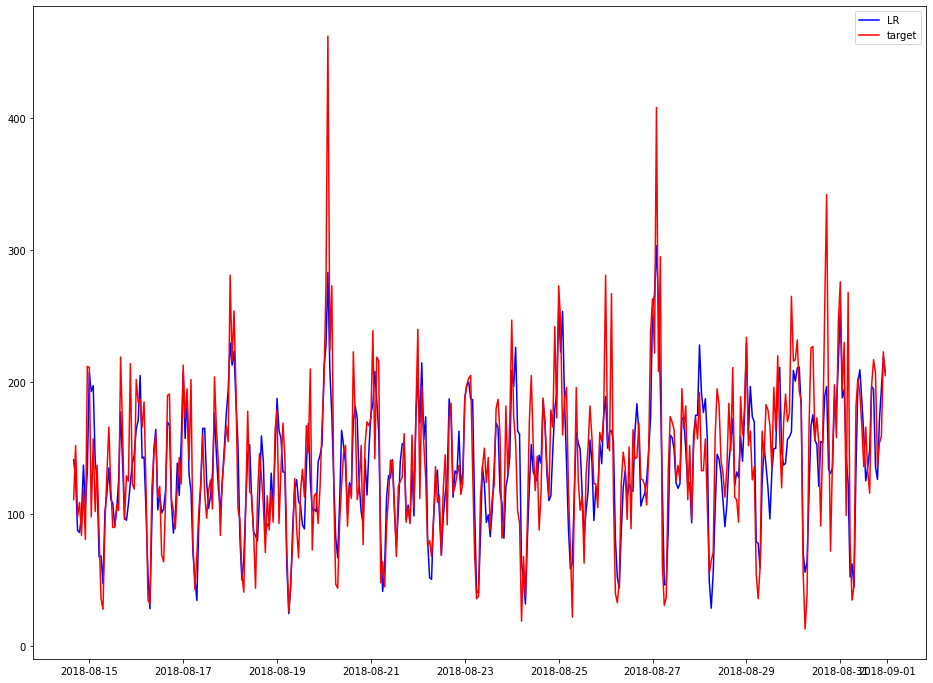

In [50]:
plt.figure(figsize=(16,12))
plt.plot(pred_lr, color='b', label='LR')
plt.plot(y_test, color='r', label='target')
plt.legend()
plt.show()

**CatBoost:**

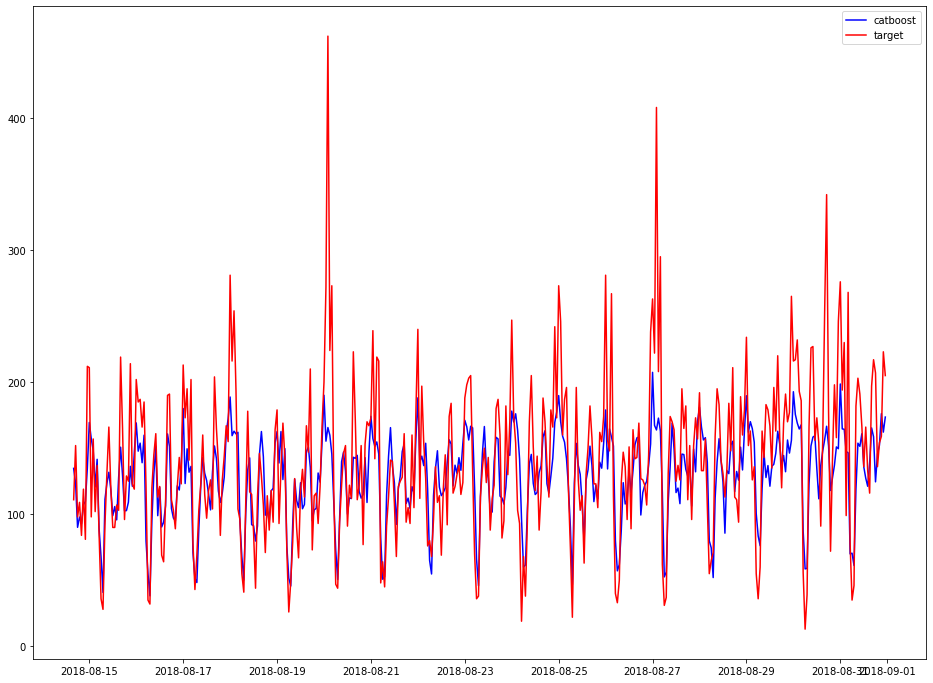

In [51]:
plt.figure(figsize=(16,12))
plt.plot(pred_cb, color='b', label='catboost')
plt.plot(y_test, color='r', label='target')
plt.legend()
plt.show()

**NN:**

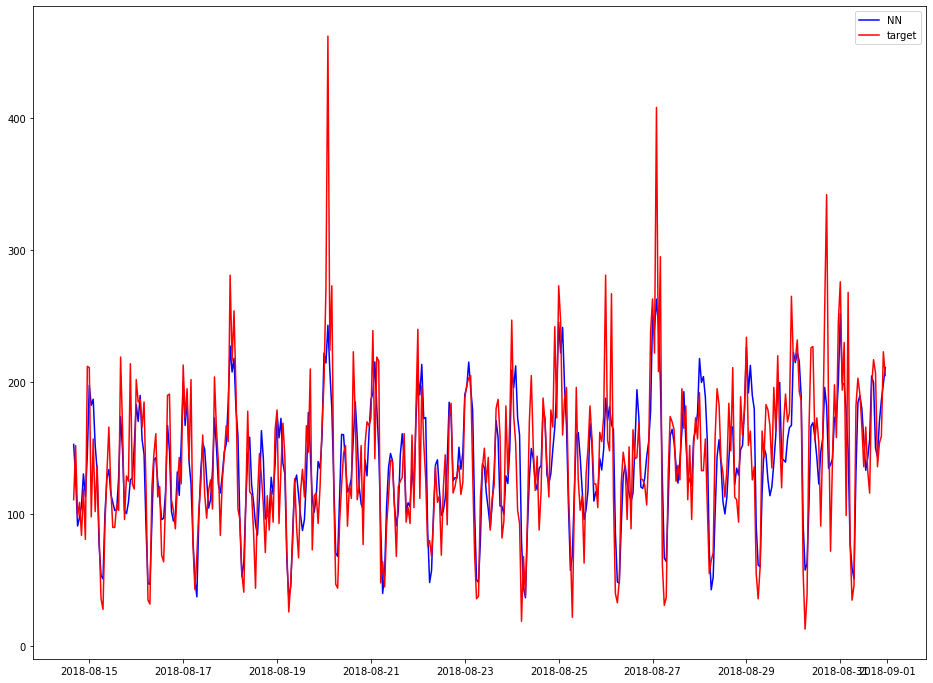

In [52]:
plt.figure(figsize=(16,12))
plt.plot(pred_nn, color='b', label='NN')
plt.plot(y_test, color='r', label='target')
plt.legend()
plt.show()

### Выводы:

Как уже было отмечено, после определенного значения MAX_LAG, качество моделей становится приблизительно одинаковым. Однако отметим следующее: если в линейную регрессию подать много lag-столбцов, то ее ошибка становится сопоставимой более сложным моделям, но она дает более "устойчивые" предсказания для прогнозов. В данном случае мы видим, что результат Катбуста на тесте даже хуже, чем ЛР. Нейросеть по итогу где-то посередине между ЛР и Катбустом. Отметим, что все построенные модели превзошли baseline. Обратим внимание, что значения ошибок на валидации и тесте существенно отличаются. Это объясняется тем, что валидационные данные ближе по смыслу к обучающим, чем тестовые (тестовые данные наиболее свежие). Таким образом мы видим, что с течением времени качество модели может ухудшаться. И отсюда, в свою очередь следует, что модели предсказаний временных рядов требуют регулярной поддержки (дообучения на свежих данных, пересмотр самой модели).